# Tutorial: ECT for example dataset

<div>
<img src="images/graphECTgif.gif" width="800" align='center'/>
</div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

# Only for testing purposes
from sys import path
path.append( "../../ect/ect" )
from ect import ECT, EmbeddedGraph


We are using a subset of the leaf shape dataset from [(Li et al., 2018)](https://www.frontiersin.org/journals/plant-science/articles/10.3389/fpls.2018.00553/full) as an example in this tutorial. Samples in the dataset are coordinates $(x,y)\in\mathbb{R}^2$ that form outlines of leaves. The data is pre-centered and scaled to account for any sampling resolution differences between leaf samples.
In the published version of the dataset, these coordinates are not ordered, however in order to represent the leaf outlines as a graph, we require the coordinates be ordered such that the outline of each leaf can be traced out by the graph representation.
To address the lack of ordering of the coordinates, we use the dataset version from [(Wiley, 2023)](https://github.com/willeyna/ECT\_of\_leaves), in which they use $2$-nearest neighbor graphs to order all coordinates so as to trace the outline of each leaf.

Using coordinates for each leaf, ordered such that connecting subsequent coordinates in forms the leaf outline, we build a graph representation of each leaf sample. Each of the coordinates of the leaf are represented as vertices in the graph, with edges between vertices that are adjacent in the leaf outline and the graph embedding defined by the coordinates $(x,y)\in\mathbb{R}^2$ for each vertex. Here is an example of the graph representation for this dataset from the Cotton class, zoomed in (right, in red) to show graph structure and the subgraph highlighted in red on the full outline graph.

<div>
<img src="images/Cotton_full.png" width="400" align='center'/>
<img src="images/Cotton_zoom.png" width="400" align='center'/>
</div>

# Load in the leaf dataset
- We will look at the full dataset of leaves [(Li et al., 2018)](https://www.frontiersin.org/journals/plant-science/articles/10.3389/fpls.2018.00553/full).
- The ECT of each leaf sample is computed and saved as a .npy file in a directory structure matching the original dataset.


### Define datasets and groups

There are multiple sub-folders per a leaf type. First, for all the folders `datasets`, we need to define the `group`, or larger leaf category the leaf falls in. Below, the code includes all sub-folder `datasets` as a list, and assigns them their correct `group` identity that we will use for building our model and predicting.

In [2]:
# a list of folder directories of datasets to analyze
datasets = ["Alstroemeria",
            "Apple",
            "Arabidopsis",
            "Arabidopsis_asymmetry",
            "Brassica/napus",
            "Brassica/rapa",
            "Coleus/Co1",
            "Coleus/Co2",
            "Coleus/Co3",
            "Coleus/Co4",
            "Coleus/Co5",
            "Coleus/Co6",
            "Cotton",
            "Grape/Domesticated_grape/GrapeJune1.2011",
            "Grape/Domesticated_grape/GrapeMay28.2011",
            "Grape/Domesticated_grape/GrapeMay29.2011",
            "Grape/Domesticated_grape/GrapeMay30.2011",
            "Grape/Domesticated_grape/GrapeMay31.2011",
            "Grape/Geneva_2013/Folder1_Jose",
            "Grape/Geneva_2013/Folder2_Tommy",
            "Grape/Geneva_2013/Folder3_Danny",
            "Grape/Geneva_2013/Folder4_Quaneisha",
            "Grape/Geneva_2013/Folder5_Susan",
            "Grape/Geneva_2013/Folder6_Darren",
            "Grape/Geneva_2013/Folder7_Jose2",
            "Grape/Geneva_2013/Folder8_Susan2",
            "Grape/Geneva_2013/Folder9_Tommy2",
            "Grape/Geneva_2013/Folder10_Quaneisha2",
            "Grape/Geneva_2013/Folder11_Darren2",
            "Grape/Geneva_2013/Folder12_Danny",
            "Grape/Geneva_2015/060815",
            "Grape/Geneva_2015/060915",
            "Grape/Geneva_2015/061015",
            "Grape/Geneva_2016/Dan_Geneva_2016",
            "Grape/Geneva_2016/MF_Geneva_2016",
            "Grape/MtVernon_scans/2014_MtVernon_Scans",
            "Grape/MtVernon_scans/2016_MtVernon_Scans",
            "Grass",
            "Ivy",
            "Leafsnap",
            "Passiflora",
            "Pepper",
            "Potato",
            "Tomato_asymmetry",
            "Tomato_BILs/B1",
            "Tomato_BILs/B2",
            "Tomato_BILs/B3",
            "Tomato_chamber/C1",
            "Tomato_chamber/C2",
            "Tomato_chamber/C3",
            "Tomato_chamber/C4",
            "Tomato_chamber/C5",
            "Tomato_entire",
            "Tomato_field/F1",
            "Tomato_field/F2",
            "Tomato_wild/WA",
            "Tomato_wild/WB",
            "Transect/Batch_1_W",
            "Transect/Batch_2_B",
            "Viburnum/V1",
            "Viburnum/V2",
           ]

# make a list of overall groups
groups = [] # store group names

for i in datasets: # for each dataset

    if ("Tomato" in i) & ("/" in i):
        groups.append(i[:i.index('_')]) # then only take up to the underscore
    
    elif "/" in i: # if there are subfolders
        groups.append(i[:i.index('/')]) # then only take the name of the first folder
    elif "_" in i: # if there is a redundant folder with "_" like Arabidopsis
        groups.append(i[:i.index('_')]) # then only take up to the underscore
    else:
        groups.append(i) # otherwise just take the whole name

We save the full path, group identity, and file name for each file to list to make a dataframe

In [3]:
# where is the leaf data
mypath = 'example_data/2017_leaves/'

# list to store full path
full_path_list = []

# list to store just file names
file_names = []

# list to store group
group_names = []

# loop through file system
classes=[]
class_count = 0
for path, subdirs, files in os.walk(mypath):
    classes.extend(subdirs)
    files = [f for f in files if not f[0] == '.']
    subdirs[:] = [d for d in subdirs if (d[0] != '.')]
    print('Computing ECT of files in ', path, '...')
    print("There are ",len(files), ' samples to load in this directory.')
    
    for name in files:
        
        input_filedir = os.path.join(path, name) # input file directory
        file = input_filedir[input_filedir.rfind("/")+1:] # get just the file name itself
        # get the full path of the folders minus file name
        full_path = input_filedir[:input_filedir.rfind("/")]
        folder = full_path[len(mypath):]
        # get the corresponding group
        group = groups[datasets.index(folder)]

        full_path_list.append(input_filedir)
        file_names.append(file)
        group_names.append(group)
        

Computing ECT of files in  example_data/2017_leaves/ ...
There are  0  samples to load in this directory.
Computing ECT of files in  example_data/2017_leaves/Apple ...
There are  9619  samples to load in this directory.
Computing ECT of files in  example_data/2017_leaves/Passiflora ...
There are  3298  samples to load in this directory.
Computing ECT of files in  example_data/2017_leaves/Ivy ...
There are  865  samples to load in this directory.
Computing ECT of files in  example_data/2017_leaves/Arabidopsis ...
There are  2168  samples to load in this directory.
Computing ECT of files in  example_data/2017_leaves/Leafsnap ...
There are  4565  samples to load in this directory.
Computing ECT of files in  example_data/2017_leaves/Grass ...
There are  866  samples to load in this directory.
Computing ECT of files in  example_data/2017_leaves/Potato ...
There are  1840  samples to load in this directory.
Computing ECT of files in  example_data/2017_leaves/Alstroemeria ...
There are  2392 

Create a dataframe and save

In [4]:
# create dataframe
df = pd.DataFrame({
    "full_path":full_path_list,
    "group":group_names,
    "file":file_names
})

# save the df
df.to_csv("2017_datasets.csv", index=False)

### Read back in info on datasets and sample files to analyze

In [5]:
# read in dataframe
df = pd.read_csv("2017_datasets.csv")

# check df
df.head()

,full_path,group,file
0,example_data/2017_leaves/Apple/4187_2_2842.npy,Apple,4187_2_2842.npy
1,example_data/2017_leaves/Apple/2151_2634.npy,Apple,2151_2634.npy
2,example_data/2017_leaves/Apple/1220_2_1744.npy,Apple,1220_2_1744.npy
3,example_data/2017_leaves/Apple/1178_692.npy,Apple,1178_692.npy
4,example_data/2017_leaves/Apple/1010_686.npy,Apple,1010_686.npy


Get counts for all the groups

In [6]:
df["group"].value_counts()

group
Tomato          82034
Coleus          34607
Grape           11379
Apple            9619
Transect         5808
Arabidopsis      5101
Leafsnap         4565
Passiflora       3298
Pepper           3277
Cotton           2885
Viburnum         2422
Alstroemeria     2392
Potato           1840
Brassica         1832
Grass             866
Ivy               865
Name: count, dtype: int64

In [7]:
rand_num = 50 # number from each group to sample
rand_state = 42 # random state for reproducibility

df_list = [] # a list of dfs to concatenated later

for g in df["group"].unique(): # for each group

    if (g == "Transect") | (g == "Leafsnap"): # skip if transect or leafsnap
        continue

    curr_group = df[df["group"]==g] # mask for the current group

    df_list.append(curr_group.sample(n=rand_num, random_state=rand_state)) # sample random rows of the group

rand_df =  pd.concat(df_list, ignore_index=True)

### Now let's calculate the ECT for all leaves

In [230]:
num_dirs = 5
num_thresh = 5

In [231]:
mypath_output = 'example_data/ect_output/'

for i in range(len(rand_df)):

    if i%100==0:
        print(i)

    ####################
    ### READ IN FILE ###
    ####################
    
    curr_path = rand_df["full_path"].iloc[i] # current path
    leaf = np.load(curr_path) # get current leaf
    group = rand_df["group"].iloc[i] # current group
    file = rand_df["file"].iloc[i] # current group
    
    #####################
    ### CALCULATE ECT ###
    #####################

    G = EmbeddedGraph() # initiate graph
    G.add_cycle(leaf) # add the shape coordinates as a graph cycle
    G.set_PCA_coordinates( center_type='min_max', scale_radius=1) # normalize the shape coordinates
    
    # initialize ECT
    myect = ECT(num_dirs = num_dirs, num_thresh = num_thresh)

    #calculate ECT
    myect.calculateECT(G)

    # The matrix is passed as an output above but is also saved internally. Get the saved matrix
    M = myect.get_ECT()

    ################
    ### SAVE ECT ###
    ################

    # save the ECT matrix as a numpy file
    # create the output file directory path
    output_filedir = os.path.join(mypath_output + group + "/" + file)
    Path(os.path.dirname(output_filedir)).mkdir(parents=True, exist_ok=True)
    Path(os.path.dirname(output_filedir)).mkdir(parents=True, exist_ok=True)
    np.save(output_filedir, M)



0
100
200
300
400
500
600


Now we have a saved dataset consisting of ECT matrices for the leaf outline dataset. We can train various models using these ECT matrices. Here, we show an example using a Convolutional Neural Network (CNN) to perform binary classification between the "Cotton" and "Ivy" classes.

# Train a CNN model on the ECT images

In [232]:
import torch # pip install torch
import argparse
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

This is the CNN model class we will use for classification, defined in `models.py`. Within this class, we specify the kernel size parameter. 
<div>
<img src="images/cnn_architecture.png" width="1000"/>
</div>

Also within `models.py`, the CNN class is defined using cylinder padding scheme for both of the convolution layers. To facilitate the illusion that the input images are cylindrical, we use padding defined by built in methods as part of the PyTorch package.
For each of the sides, where we want the left edge to be identified with the right edge of the image, we use circular padding which uses copies of columns from the right side to pad the left and copies of the left side to pad the right. On the top and bottom of each image, we pad with zero-valued pixels, which is a standard choice for computer vision tasks.
<div>
<img src="images/cylinder_and_zero_padding.jpeg" width="500"/>
</div>

In [233]:
from models import CNN

These functions allow us to define datasets and load them into PyTorch. The dataset classes and data loaders can be adjusted in `dataloaders.py`.

In [234]:
from dataloaders import create_datasets, create_data_loaders
from utils import save_model, save_plots, save_cf, SaveBestModel

Here we define a few model training parameters: the number of epochs to train the model and the learning rate. We also use a batch size of 4 samples, which is defined in `dataloaders.py`.

In [235]:
NUM_EPOCHS = 50 # number of epochs to train the network for; type=int
LEARNING_RATE = 1e-3 # learning rate for training; type=float

In [236]:
# device
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cpu



### Load in the dataset and split into training and test datasets

Next, we build the training and test datasets as well as the dataloaders for each.

In [237]:
train_dataset, test_dataset = create_datasets()

train_loader, test_loader = create_data_loaders(train_dataset, test_dataset)

['Apple', 'Passiflora', 'Ivy', 'Arabidopsis', 'Grass', 'Potato', 'Alstroemeria', 'Cotton', 'Viburnum', 'Grape', 'Brassica', 'Pepper', 'Tomato', 'Coleus']
num_classes= 14
ECT data; using only normalize, rotation transforms on training data


Now, show a few samples from the training dataset. The labels for this example batch are printed as the title of each, where 0 indicates Ivy and 1 indicates Cotton'

In [238]:
trainimages, trainlabels = next(iter(train_loader))
print(f'The tensor shape of each batch in the training dataset is \n[batch_size, num_channels, num_directions, num_thresholds]: {trainimages.shape}')

The tensor shape of each batch in the training dataset is 
[batch_size, num_channels, num_directions, num_thresholds]: torch.Size([4, 1, 5, 5])


training images torch.Size([4, 1, 5, 5])


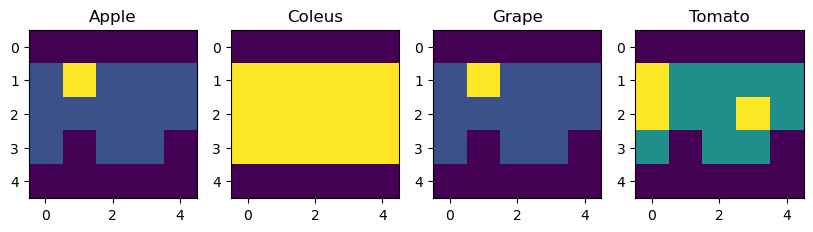

In [249]:
plt.style.use('default')
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
print('training images', trainimages.shape)
for i in range(4):
    ax = axes[i]
    ax.imshow(trainimages[i,0,:,:].T, cmap='viridis')
    label = train_dataset.get_label(trainlabels[i])
    ax.set_title(label)
plt.show()

Next, we define two functions: `train()` and `validate()`. These define the training scheme and keep track of the loss during training (and validation) as well as the model accuracy.

In [240]:
def train(model, train_loader, optimizer, lossfcn):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = lossfcn(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(train_loader.dataset))
    return epoch_loss, epoch_acc

In [241]:
# function for validation
def validate(model, valid_loader, lossfcn):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        outputs_list = []
        labels_list = []
        for i, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            outputs_list.append(outputs)
            labels_list.append(labels)
            # calculate the loss
            loss = lossfcn(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(valid_loader.dataset))

    return epoch_loss, epoch_acc

Here, we specify the model to be used for training and print out a summary of the layers in the model.

In [242]:
model = CNN(num_classes=train_dataset.num_classes, num_channels=trainimages.shape[1],input_resolution=(num_dirs,num_thresh)).to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=14, bias=True)
)


We can also print out the total number of parameters and trainable parameters for the model for reference.

In [243]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

37,774 total parameters.
37,774 training parameters.



Next, we specifify the optimizer and loss function to be used for training. In this case we use the Adam optimizer built into PyTorch, which uses a gradient descent algorithm. We use a cross entropy loss function built into PyTorch, which computes the difference between two probability distributions and outputs a score (between 0 and 1, where 0 is a perfect score) summarizing the average difference between the predicted and actual values during training.

In [244]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
# loss function
lossfcn = nn.CrossEntropyLoss()
# initialize SaveBestModel class
save_best_model = SaveBestModel()

Now we actually train the model using our previously defined `train()` function! During training, we keep track of overall loss and accuracy values so that we can plot the behavior of the model throughout training.

In [245]:
train_loss, valid_loss = [],[]
train_acc, valid_acc = [],[]

# begin training
for epoch in range(1,NUM_EPOCHS+1):
    print(f"[INFO]: Epoch {epoch} of {NUM_EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, lossfcn)
    valid_epoch_loss, valid_epoch_acc = validate(model, test_loader, lossfcn)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

    # save the best model up to current epoch, if we have the least loss in the current epoch
    save_best_model(
        valid_epoch_loss, epoch, model, optimizer, lossfcn
    )
    print('-'*50)
    

[INFO]: Epoch 1 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 8.102, training acc: 8.929
Validation loss: 2.682, validation acc: 4.286

Best validation loss: 2.6824876376560756

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.664, training acc: 7.679
Validation loss: 2.694, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.645, training acc: 6.607
Validation loss: 2.658, validation acc: 5.000

Best validation loss: 2.6575966971261162

Saving best model for epoch: 3

--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.650, training acc: 6.786
Validation loss: 2.659, validation acc: 5.000
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.644, training acc: 5.357
Validation loss: 2.655, validation acc: 4.286

Best validation loss: 2.6549134254455566

Saving best model for epoch: 5

--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.642, training acc: 6.607
Validation loss: 2.674, validation acc: 7.857
--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.645, training acc: 6.071
Validation loss: 2.659, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.653, training acc: 7.679
Validation loss: 2.670, validation acc: 5.000
--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.641, training acc: 7.500
Validation loss: 2.661, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.638, training acc: 6.429
Validation loss: 2.658, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.639, training acc: 5.357
Validation loss: 2.657, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.642, training acc: 5.893
Validation loss: 2.657, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.641, training acc: 5.536
Validation loss: 2.659, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.640, training acc: 7.857
Validation loss: 2.659, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.641, training acc: 6.964
Validation loss: 2.660, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.641, training acc: 5.893
Validation loss: 2.658, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.641, training acc: 7.143
Validation loss: 2.658, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.641, training acc: 5.893
Validation loss: 2.656, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.641, training acc: 6.071
Validation loss: 2.657, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.642, training acc: 6.786
Validation loss: 2.657, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.638, training acc: 7.143
Validation loss: 2.658, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.655, training acc: 6.071
Validation loss: 2.656, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.641, training acc: 6.786
Validation loss: 2.656, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.641, training acc: 7.857
Validation loss: 2.656, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.640, training acc: 7.143
Validation loss: 2.656, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.641, training acc: 5.536
Validation loss: 2.657, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.640, training acc: 6.250
Validation loss: 2.658, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.641, training acc: 6.964
Validation loss: 2.657, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.640, training acc: 7.143
Validation loss: 2.657, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.641, training acc: 6.071
Validation loss: 2.658, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.640, training acc: 6.429
Validation loss: 2.656, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.641, training acc: 6.964
Validation loss: 2.657, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.640, training acc: 6.607
Validation loss: 2.658, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.642, training acc: 6.071
Validation loss: 2.657, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.639, training acc: 6.429
Validation loss: 2.656, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.640, training acc: 6.607
Validation loss: 2.657, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.640, training acc: 6.964
Validation loss: 2.657, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.640, training acc: 6.071
Validation loss: 2.656, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.643, training acc: 7.500
Validation loss: 2.656, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.641, training acc: 7.321
Validation loss: 2.657, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.640, training acc: 7.679
Validation loss: 2.654, validation acc: 4.286

Best validation loss: 2.6544471740722657

Saving best model for epoch: 41

--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.640, training acc: 5.893
Validation loss: 2.661, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.640, training acc: 7.857
Validation loss: 2.656, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.639, training acc: 7.321
Validation loss: 2.656, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.639, training acc: 6.607
Validation loss: 2.656, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.641, training acc: 5.357
Validation loss: 2.656, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.640, training acc: 7.857
Validation loss: 2.654, validation acc: 4.286

Best validation loss: 2.6541341849735804

Saving best model for epoch: 47

--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.650, training acc: 8.036
Validation loss: 2.657, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.640, training acc: 6.786
Validation loss: 2.656, validation acc: 4.286
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


  0%|          | 0/140 [00:00<?, ?it/s]

Validation


  0%|          | 0/35 [00:00<?, ?it/s]

Training loss: 2.639, training acc: 6.429
Validation loss: 2.656, validation acc: 4.286
--------------------------------------------------


Finally, we save the trained model weights and the loss and accuracy plots.

Saving final model...


(<Figure size 1000x700 with 1 Axes>, <Figure size 1000x700 with 1 Axes>)

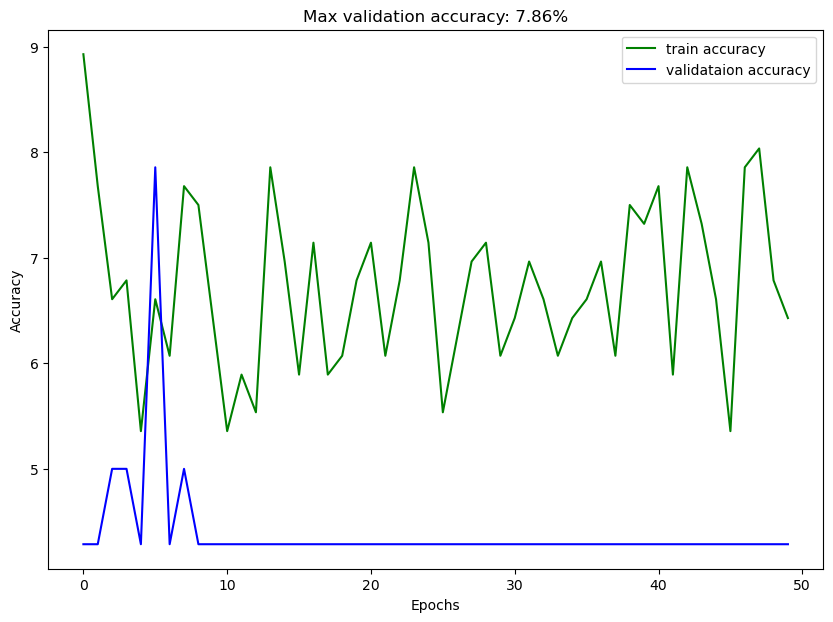

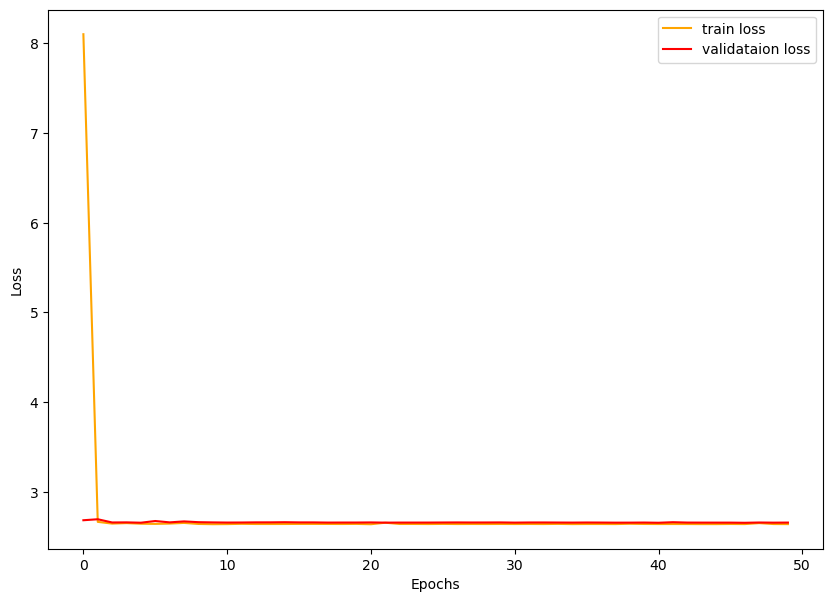

In [246]:
save_model(NUM_EPOCHS, model, optimizer, lossfcn)
save_plots(train_acc, valid_acc, train_loss, valid_loss)

We can also visualize the model performance after training is complete thorugh a confusion matrix. We load in the best model and plot the confusion matrix.

Using validation to compute confusion matrix


/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_3655/246017674.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('outputs/best_model.pth

  0%|          | 0/35 [00:00<?, ?it/s]

classes: ['Apple', 'Passiflora', 'Ivy', 'Arabidopsis', 'Grass', 'Potato', 'Alstroemeria', 'Cotton', 'Viburnum', 'Grape', 'Brassica', 'Pepper', 'Tomato', 'Coleus']
Test Result:
Accuracy Score: 4.29%
_______________________________________________
CLASSIFICATION REPORT:
             0     1     2    3    4    5     6     7    8         9    10  \
precision  0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.042857   0.0   
recall     0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0  0.0  1.000000   0.0   
f1-score   0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.082192   0.0   
support    9.0  11.0  13.0  7.0  6.0  7.0  15.0  12.0  9.0  6.000000  11.0   

             11    12    13  accuracy   macro avg  weighted avg  
precision   0.0   0.0   0.0  0.042857    0.003061      0.001837  
recall      0.0   0.0   0.0  0.042857    0.071429      0.042857  
f1-score    0.0   0.0   0.0  0.042857    0.005871      0.003523  
support    10.0  12.0  12.0  0.042857  140.000000    140.000000  
__________

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


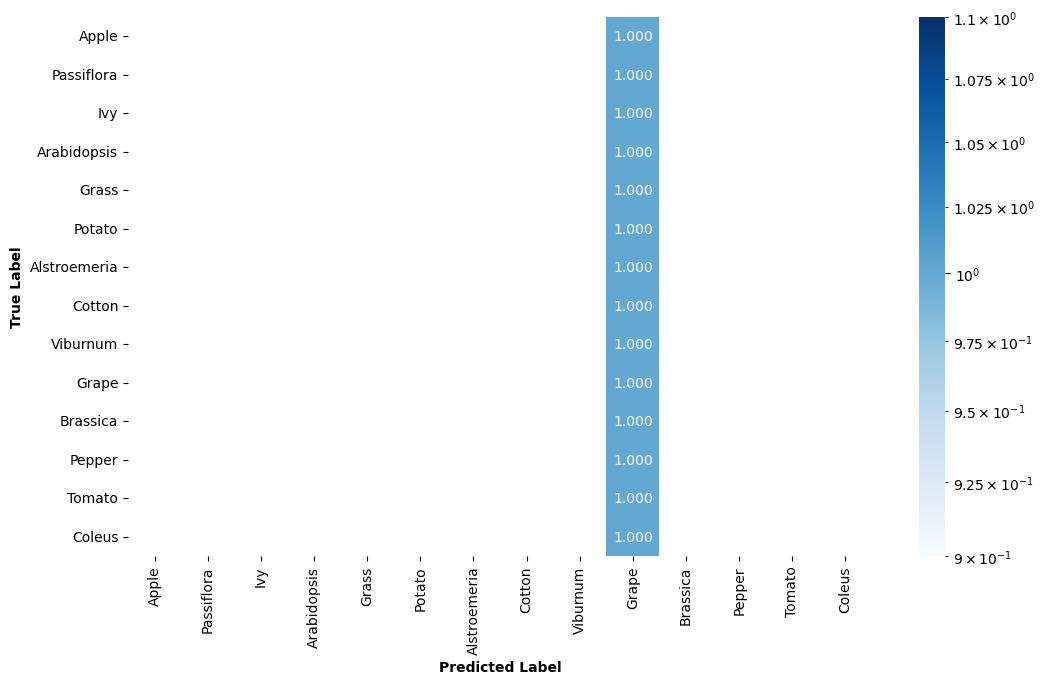

In [247]:
# model, valid_loader, lossfcn
model = CNN(num_classes=train_dataset.num_classes, num_channels=trainimages.shape[1],input_resolution=(num_dirs,num_thresh))

state_dict = torch.load('outputs/best_model.pth')['model_state_dict']
model.load_state_dict(state_dict)
model.eval()
model = model.to(device)
print('Using validation to compute confusion matrix')
valid_running_pred = []
valid_running_labels = []
counter = 0
with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
        counter += 1
        
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        # forward pass
        outputs = model(image)
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)

        valid_running_pred.append(preds)
        valid_running_labels.append(labels)
    
# confusion matrix for the complete epoch
valid_running_pred = torch.cat(valid_running_pred)
valid_running_labels = torch.cat(valid_running_labels)
print('classes:',test_dataset.classes)
save_cf(valid_running_pred.cpu(),valid_running_labels.cpu(), test_dataset.classes)